In [1]:
import os
import sys
import pickle
import random
import argparse
import numpy as np
import hvplot
import scienceplots
import hvplot.pandas
import holoviews as hv
from holoviews import opts
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import torch
from mpl_toolkits.mplot3d import Axes3D
import subprocess
from holoviews.operation.datashader import datashade, shade, dynspread
from holoviews import QuadMesh
from scipy.interpolate import griddata
import plotly.graph_objects as go
from scipy.interpolate import interp1d
from collections import namedtuple
from collections import namedtuple
from experiments.exp_long_term_forecasting_discrete import Exp_Long_Term_Forecast_Discrete
from utils.tools import compute_global_min_max, separate_interval
hv.extension('bokeh')

pd.options.plotting.backend = 'holoviews'
hv.renderer('bokeh').theme = 'dark_minimal'

%matplotlib inline
fix_seed = 2019
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [2]:
# Matplotlib configuration
plt.style.use(['science', 'nature', 'no-latex'])
plt.rcParams['figure.dpi'] = 240
plt.rcParams['savefig.dpi'] = 240
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
# MODELS = [
#     "results/Intnone_0_iTransformer_custom_M_ft48_sl24_ll24_pl128_dm1_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0",
#     "results/Intgen_0_iTransformer_custom_M_ft48_sl24_ll24_pl128_dm1_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0",
#     "results/Intdisc_4_iTransformer_custom_M_ft48_sl24_ll24_pl128_dm4_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0",
#     "results/Intdisc_8_iTransformer_custom_M_ft48_sl24_ll24_pl128_dm4_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0"
# ]

# PLOT_SAVE_PATHS = [
#     "plots/Intnone_4_intervals_comp_pattern",
#     "plots/Intgen_4_intervals_comp_pattern",
#     "plots/Intdisc_4_4_intervals_comp_pattern",
#     "plots/Intdisc_8_4_intervals_comp_pattern"
# ]

# MODEL_NAMES = ['Intnone', 'Intgen', 'Intdisc_4', 'Intdisc_8']
MODELS = [
    "results/Intdisc_8_iTransformer_custom_M_ft48_sl24_ll24_pl128_dm4_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0"
]

PLOT_SAVE_PATHS = [
    "plots/Intdisc_8_4_intervals_comp_pattern"
]

MODEL_NAMES = ['Intdisc_8']

END_IDX = 25

COLORS = ["blue", "orange", "green", "red", "olivedrab"]
COLORS_MODEL_COMP = ["blue", "orange", "green", "red", "olivedrab"]
train_int_min, train_int_max = 0.0, 1.0
NR_INTERVALS = 4
INTERVAL_LIST = separate_interval(
            interval=[train_int_min, train_int_max],
            nr_intervals=NR_INTERVALS
        )

In [4]:
def run_stats_script(l, u):
    subprocess.run(
        ["bash", "./scripts/multivariate_forecasting/Wireless/stats.sh", str(l), str(u)],
        capture_output=True,
        text=True,
        check=True
    )

def load_data(base_path):
    preds = np.load(f"{base_path}/pred.npy")
    trues = np.load(f"{base_path}/true.npy")
    return preds, trues

def compute_time_lagged_mean_std(data, T, feature_index=0, end_idx=25):
    data = data[:T, :, :]
    length = data.shape[0] + data.shape[1]
    single_curve_dict = {n: [] for n in range(length)}
    
    for t in range(data.shape[0]):
        row = data[t, :, feature_index]  
        for offset, idx in enumerate(range(t, t + len(row))):
            single_curve_dict[idx].append(row[offset])
    
    mean_curve = np.array([np.mean(single_curve_dict[idx]) for idx in single_curve_dict])
    std_curve = np.array([np.std(single_curve_dict[idx]) for idx in single_curve_dict])
    
    return mean_curve, std_curve

def get_results_for_interval(l, u, T, N, base_path, end_idx=25):
    run_stats_script(l, u)
    
    preds, trues = load_data(base_path)
    
    preds_mean, preds_std = compute_time_lagged_mean_std(preds, T, N, end_idx)
    trues_mean, _         = compute_time_lagged_mean_std(trues, T, N, end_idx)
    
    return {
        "Mean": preds_mean,
        "Std": preds_std,
        "True": trues_mean,
    }

def plot_results_intervals_comp(results_dict, intervals, T, N, base_path, model_idx, save_path=None):
    fig, ax = plt.subplots(figsize=(14, 4))
    
    first_model_key = next(iter(results_dict))
    x_range = len(results_dict[first_model_key]["Mean"])
    x_vals = np.arange(x_range)
    
    _, trues = load_data(base_path)
    trues_sliced = trues[:T, :, :]
    
    for i, (l, u) in enumerate(intervals):
        model_key = f"{MODEL_NAMES[model_idx]}({l}, {u})"
        curve_m = results_dict[model_key]["Mean"]
        curve_std = results_dict[model_key]["Std"]
        curve_t = results_dict[model_key]["True"]
        
        ax.fill_between(
            x_vals,
            curve_m - curve_std,
            curve_m + curve_std,
            color=COLORS[i],
            linewidth=1,
            linestyle='-',
            alpha=0.2
        )
        ax.plot(curve_t, color='black', linewidth=1, linestyle=':')
        ax.plot(curve_m, color=COLORS[i], linewidth=1, linestyle='-', label=model_key)
        ax.fill_between([0, x_range], [l, l], [u, u], color=COLORS[i], alpha=0.1)

    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_results_models_comp(l, u, results_dict, models, T, N, base_path, save_path=None):
    fig, ax = plt.subplots(figsize=(4, 4))
    
    first_model_key = next(iter(results_dict))
    x_range = len(results_dict[first_model_key]["Mean"])
    x_vals = np.arange(x_range)
    
    _, trues = load_data(base_path)
    trues_sliced = trues[:T, :, :]
    
    for i, model_key in enumerate(models):
        model_key = f"{MODEL_NAMES[i]}({l}, {u})"
        curve_m = results_dict[model_key]["Mean"]
        curve_std = results_dict[model_key]["Std"]
        curve_t = results_dict[model_key]["True"]
        
        ax.fill_between(
            x_vals,
            curve_m - curve_std,
            curve_m + curve_std,
            color=COLORS_MODEL_COMP[i],
            linewidth=1,
            linestyle='-',
            alpha=0.2
        )
        ax.plot(curve_t, color='black', linewidth=1, linestyle=':')
        ax.plot(curve_m, color=COLORS_MODEL_COMP[i], linewidth=1, linestyle='-', label=model_key)
        ax.fill_between([0, x_range], [l, l], [u, u], color='grey', alpha=0.1)

    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

Plotting results for model: results/Intdisc_8_iTransformer_custom_M_ft48_sl24_ll24_pl128_dm4_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0


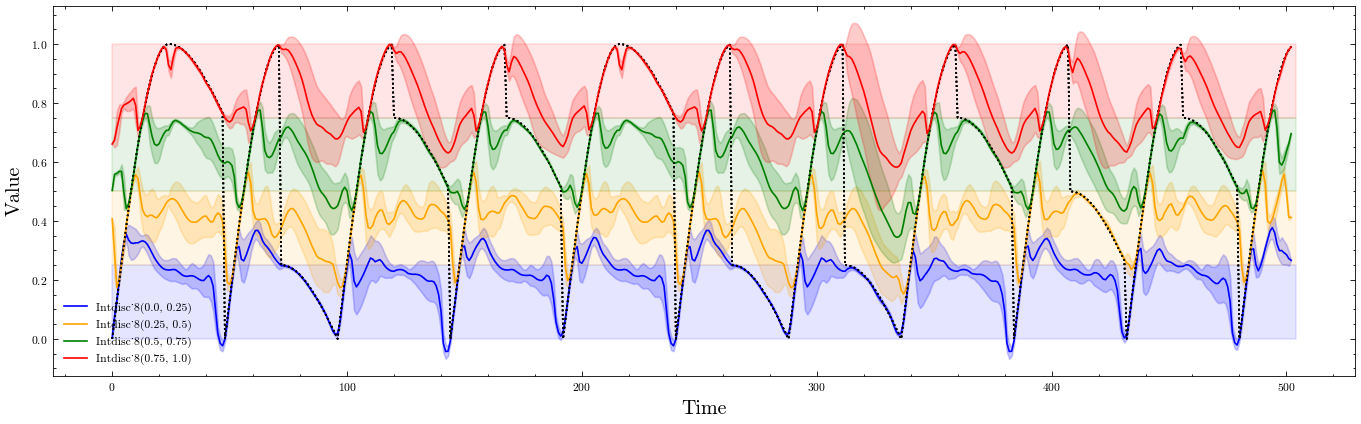

In [6]:
T_LIST = [24 * 18, 24 * 0, 24 * 4, 24 * 10]
T_LIST = [480]
N = 0

for i, BASE_PATH in enumerate(MODELS):
    print(f'Plotting results for model: {BASE_PATH}')
    for j, T in enumerate(T_LIST):
        results = {}
        
        for (l, u) in INTERVAL_LIST:
            model_name = f"{MODEL_NAMES[i]}({l}, {u})"
            results[model_name] = get_results_for_interval(l, u, T=T, N=N, base_path=BASE_PATH, end_idx=END_IDX)
    
        PLOT_SAVE_PATH = PLOT_SAVE_PATHS[i] + f'_no_decay_expectation_train_{j + 1}.png'
            
        plot_results_intervals_comp(results, INTERVAL_LIST, T=T, N=N, base_path=BASE_PATH, model_idx=i,save_path=PLOT_SAVE_PATH)

Plotting results for interval (0.0, 0.25)
MAE for the interval (0.0, 0.25) for model Intdisc_4: 0.002132193883880973
MAE for the interval (0.0, 0.25) for model Intdisc_8: 0.0009440502617508173


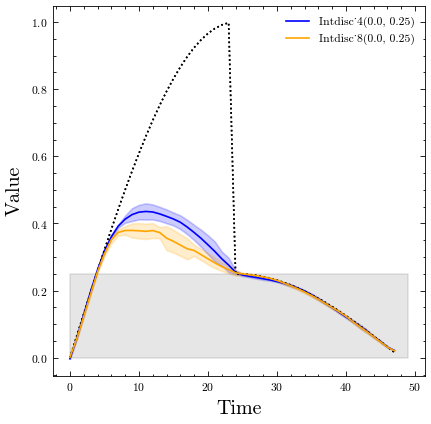

Plotting results for interval (0.25, 0.5)
MAE for the interval (0.25, 0.5) for model Intdisc_4: 0.0018597650341689587
MAE for the interval (0.25, 0.5) for model Intdisc_8: 0.0007430799887515604


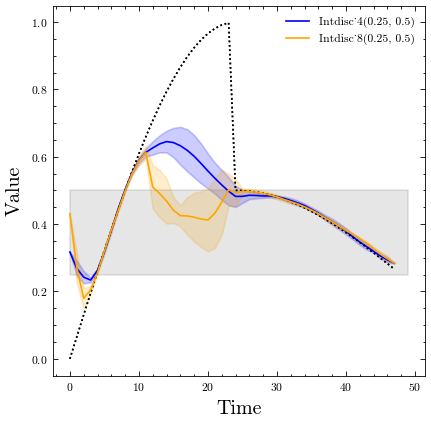

Plotting results for interval (0.5, 0.75)
MAE for the interval (0.5, 0.75) for model Intdisc_4: 0.008317050524055958
MAE for the interval (0.5, 0.75) for model Intdisc_8: 0.0009137711604125798


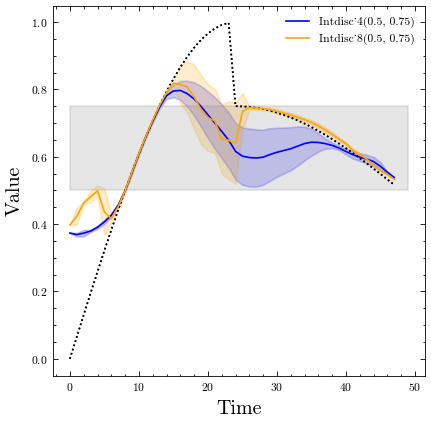

Plotting results for interval (0.75, 1.0)
MAE for the interval (0.75, 1.0) for model Intdisc_4: 0.003706498071551323
MAE for the interval (0.75, 1.0) for model Intdisc_8: 0.0009923622710630298


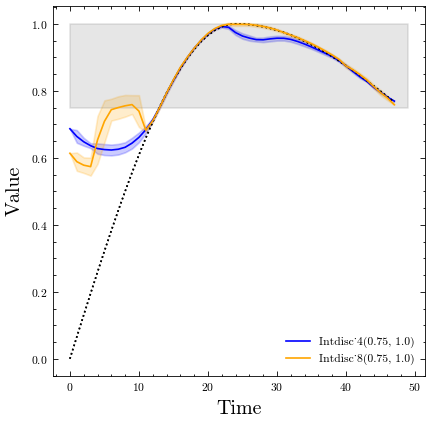

In [30]:
T_LIST = [24 * 18, 24 * 0, 24 * 4, 24 * 10]
N = 0

for j, (l, u) in enumerate(INTERVAL_LIST):
    print(f'Plotting results for interval ({l}, {u})')
    results = {}

    run_stats_script(l, u)
            
    for i, BASE_PATH in enumerate(MODELS):
        model_name = f"{MODEL_NAMES[i]}({l}, {u})"

        preds, trues = load_data(BASE_PATH)
        mae = np.load(f'{BASE_PATH}/metrics.npy')[0]
        print(f"MAE for the interval ({l}, {u}) for model {MODEL_NAMES[i].split('/')[0].split('_')[0] + '_' + MODEL_NAMES[i].split('/')[0].split('_')[1]}: {mae}")
        
        preds_mean, preds_std = compute_time_lagged_mean_std(preds, T_LIST[j], N, END_IDX)
        trues_mean, _         = compute_time_lagged_mean_std(trues, T_LIST[j], N, END_IDX)
    
        results[model_name] = { "Mean": preds_mean, "Std": preds_std, "True": trues_mean}
    
    PLOT_SAVE_PATH = f"plots/Comparison_Interval_({l}, {u})_discrete_decay_naive.png"
            
    plot_results_models_comp(l, u, results, MODELS, T=T_LIST[j], N=N, base_path=BASE_PATH, save_path=PLOT_SAVE_PATH)

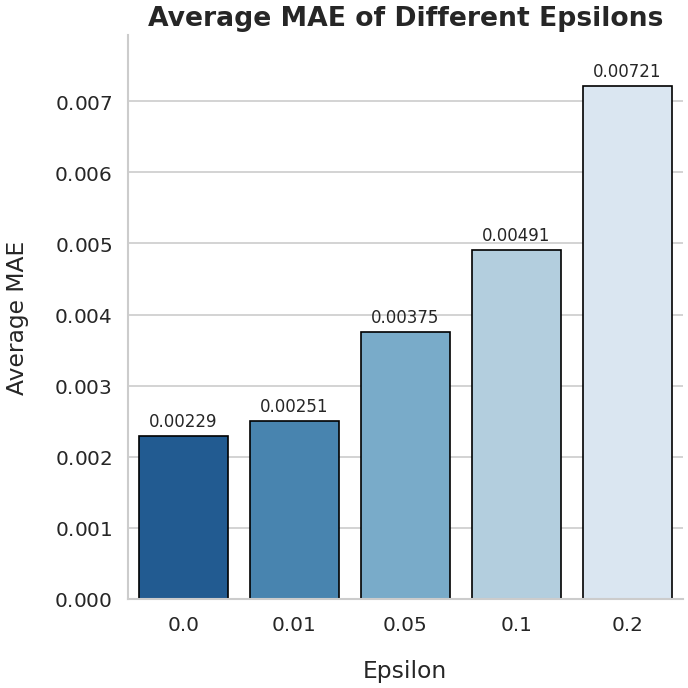

In [6]:
df = pd.DataFrame(data)
df['avg_mae'] = df.loc[:, "[0, 0.25]": "[0.75, 1]"].mean(axis=1)

plt.figure(figsize=(6, 6))
sns.set_theme(style="whitegrid")

colors = sns.color_palette("Blues_r", len(df))
ax = sns.barplot(x='Epsilon', y='avg_mae', data=df, palette=colors, edgecolor="black")

plt.xlabel('Epsilon', fontsize=14, labelpad=15)
plt.ylabel('Average MAE', fontsize=14, labelpad=15)
plt.title('Average MAE of Different Epsilons', fontsize=16, fontweight='bold')

plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.5f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10)

plt.ylim(0, df['avg_mae'].max() * 1.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('plots/8_intervals_mae_bar_plot_4_intervals.png', dpi=300)
plt.show()

In [8]:
BASE_PATH = "results/Intdisc_4_iTransformer_custom_M_ft48_sl24_ll24_pl128_dm4_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0_eps0.01"
PLOT_SAVE_PATH_REG = 'plots/pred_sliding_plot_exp_eps.png'
PLOT_SAVE_PATH_CLS = 'plots/cls_sliding_plot_exp_eps.png'
train_int_min, train_int_max = 0.0, 1.0
NR_INTERVALS = 4
FACTOR = 0.5
INTERVAL_LIST = separate_interval(
            interval=[train_int_min, train_int_max],
            nr_intervals=NR_INTERVALS
        )
COLORS = ["blue", "orange", "green", "red"]

def sliding_plot(flag='reg', true_cls_index=-1, T=0, interval_length=24, step_size=6, save_path=True):
    sample_indices = np.arange(T, T + 24 * 2, step_size).astype(int)
    feature_index = 0
    spacing = 1
    fig, ax = plt.subplots(figsize=(4, 4))
    
    for j, interval in enumerate(INTERVAL_LIST):
        subprocess.run(
            ["bash", "./scripts/multivariate_forecasting/Wireless/stats.sh", str(interval[0]), str(interval[1])],
            capture_output=True,
            text=True,
            check=True
        )
        if flag == 'reg':
            preds = np.load(f"{BASE_PATH}/pred.npy")
            trues = np.load(f"{BASE_PATH}/true.npy")
        elif flag == 'cls':
            preds = np.load(f"{BASE_PATH}/preds_cls.npy")
            trues = np.load(f"{BASE_PATH}/trues_cls.npy")

        true_color = '#1f1f1f'  
        pred_color = COLORS[j]
           
        ax.tick_params(axis='both', which='major')
        ax.tick_params(axis='both', which='minor')
        
        for i, t in enumerate(sample_indices):
            if flag == 'reg':
                pred_x = np.arange(t + 2 * interval_length, t + 3 * interval_length)
                y_min = interval[0] + spacing * i
                y_max = interval[1] + spacing * i
                
                ax.plot(np.arange(t, t + interval_length * 3), 
                        np.array(list(trues[t, :, feature_index]) + \
                                 list(trues[t + interval_length , :, feature_index]  ) + \
                                 list(trues[t + 2 * interval_length , :, feature_index])) + spacing * i, 
                        color=true_color, linewidth=0.5, label=f'True values' if j == 0 and i == 0 else "", zorder=5, linestyle = '--')
                ax.plot(np.arange(t + 2 * interval_length , t + 3 * interval_length ),
                        preds[t + 2 * interval_length , :, feature_index] + spacing * i, 
                        color=pred_color, alpha=0.9, linewidth=1, label=f'Pred on ({interval[0]}, {interval[1]})' if i == 0 else "", zorder=6)
                ax.fill_between(pred_x, y_min, y_max, color=pred_color, alpha=0.1)
            elif flag == 'cls':
                if true_cls_index in range(len(INTERVAL_LIST)) and j == true_cls_index:
                    ax.plot(np.arange(t, t + interval_length * 3), 
                        np.array(list(trues[t, :, feature_index]) + \
                                 list(trues[t + interval_length , :, feature_index]  ) + \
                                 list(trues[t + 2 * interval_length , :, feature_index])) + spacing * i, 
                        color=true_color, linewidth=0.5, label=f'True values' if i == 0 else "", zorder=5, linestyle = '--')
                    
                ax.plot(np.arange(t + 2 * interval_length , t + 3 * interval_length ),
                        preds[t + 2 * interval_length , :, feature_index] + spacing * i, 
                        color=pred_color, alpha=0.9, linewidth=1, label=f'Pred on ({interval[0]}, {interval[1]})' if i == 0 else "", zorder=6)
                
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()
    
    if save_path and flag == 'reg':
        plt.savefig(PLOT_SAVE_PATH_REG)
    elif save_path and flag == 'cls':
        plt.savefig(PLOT_SAVE_PATH_CLS)
    plt.show()

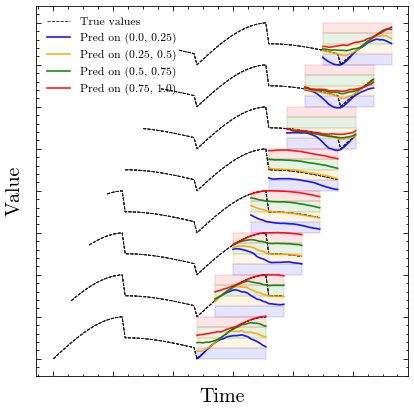

In [9]:
sliding_plot(flag='reg')

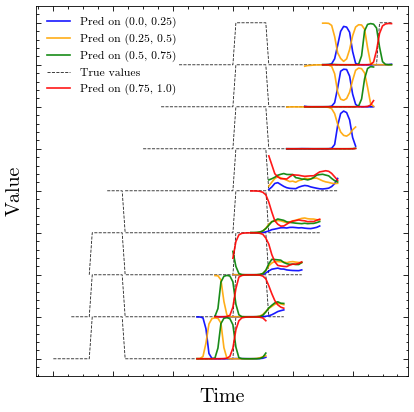

In [10]:
sliding_plot(flag='cls', true_cls_index=3)

In [ ]:
BASE_PATH = "results/Intdisc_4_iTransformer_custom_M_ft48_sl24_ll24_pl128_dm4_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0"
preds, trues,preds_cls, trues_cls  = load_data(base_path=BASE_PATH)
T = 0
sample_indices = np.arange(T, T + 24, 3).astype(int)
feature_index = 0

def sliding_plot_input_24(preds, trues, T=T):
    layout = pd.DataFrame().hvplot()
    for i, t in enumerate(sample_indices):
        df = pd.DataFrame({'True': trues[t, :, feature_index] - i, 'index': np.arange(t, t + 24)})
        plot = df.hvplot.line(y='True', x='index', label='True', color='black')
    
        df = pd.DataFrame({'True': trues[t + 24, :, feature_index] - i, 'index': np.arange(t + 23, t + 47)})
        plot *= df.hvplot.line(y='True', x='index', label='True', color='black')
        
        df = pd.DataFrame({f'Pred': preds[t + 24, :, feature_index] - i, 'index': np.arange(t + 23, t + 47)})
        plot *= df.hvplot(x='index', y=f'Pred', label=f'Pred',
                            alpha=1, color='yellow', line_width=.8)
    
        plot.opts(title=f'Sample t={t}', xlabel='Time', ylabel='Value', width=1000, height=600)
        layout *= plot
    return layout

def sliding_plot_input_48(preds, trues, T=T):
    layout = pd.DataFrame().hvplot()
    for i, t in enumerate(sample_indices):
        df = pd.DataFrame({'True': trues[t, :, feature_index] - i, 'index': np.arange(t, t + 24)})
        plot = df.hvplot.line(y='True', x='index', label='True', color='black')
    
        df = pd.DataFrame({'True': trues[t + 24, :, feature_index] - i, 'index': np.arange(t + 23, t + 47)})
        plot *= df.hvplot.line(y='True', x='index', label='True', color='black')
    
        df = pd.DataFrame({'True': trues[t + 47, :, feature_index] - i, 'index': np.arange(t + 46, t + 70)})
        plot *= df.hvplot.line(y='True', x='index', label='True', color='black')
        
        df = pd.DataFrame({f'Pred': preds[t + 47, :, feature_index] - i, 'index': np.arange(t + 46, t + 70)})
        plot *= df.hvplot(x='index', y=f'Pred', label=f'Pred',
                            alpha=1, color='yellow', line_width=.8)
    
        plot.opts(title=f'Sample t={t}', xlabel='Time', ylabel='Value', width=1000, height=600)
        layout *= plot
    return layout

layout = sliding_plot_input_48(preds, trues)
layout.opts(width = 800)

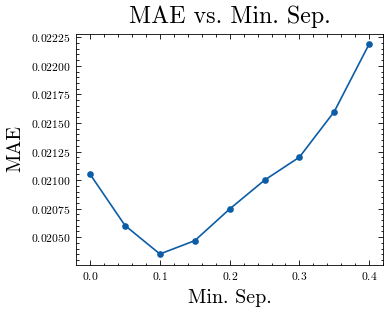

In [6]:
min_sep = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
mae = [0.0210504, 0.0206023, 0.0203529, 0.0204698, 0.0207468, 0.0209995, 0.0212008, 0.0216001, 0.0221917]

plt.plot(min_sep, mae, marker='o')
plt.xlabel("Min. Sep.")
plt.ylabel("MAE")
plt.title("MAE vs. Min. Sep.")
plt.grid(False)
plt.savefig('plots/w_hat.png')
plt.show()

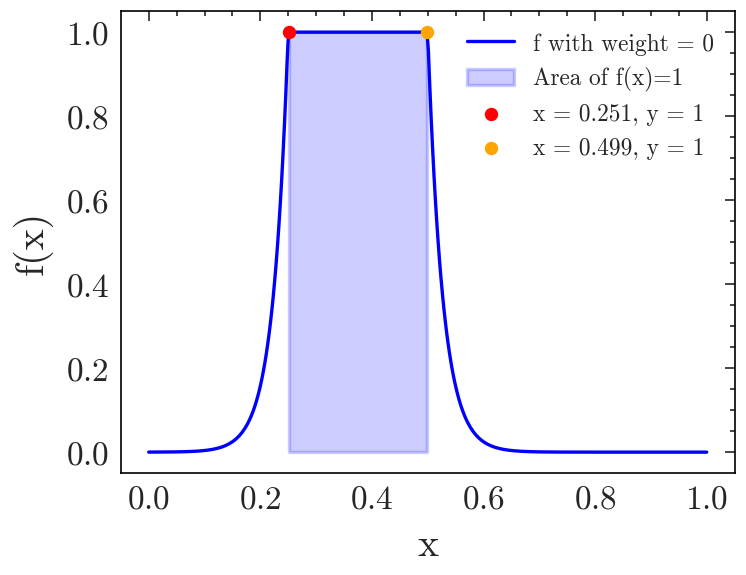

In [4]:
# Define the function
def func(x, rate, l, u):
    return np.exp(-rate * max(0, (np.abs(x - (l + u) / 2) - (u - l) / 2)))

rate = 37
l, u = 0.25, 0.5

x_values = np.linspace(0, 1, 400)
y_values = np.array([func(x, rate, l, u) for x in x_values])
x_ones = x_values[y_values == 1]

ax = plt.gca()
ax.set_facecolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

plt.plot(x_values, y_values, label=f'f with weight = 0', color='blue')

plt.fill_between(x_values, 0, 1, where=((x_values >= x_ones[0]) & (x_values <= x_ones[-1])), 
                 color='blue', label='Area of f(x)=1', alpha=0.2)

first_point_x = x_ones[0]
last_point_x = x_ones[-1]
first_point_y = 1  
last_point_y = 1
plt.scatter(first_point_x, first_point_y, color='red', zorder=5, label=f"x = {first_point_x:.3f}, y = {first_point_y}")
plt.scatter(last_point_x, last_point_y, color='orange', zorder=5, label=f"x = {last_point_x:.3f}, y = {last_point_y}")

plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(False)
if not os.path.isdir(f'plots/naive_function/'):
    os.makedirs(f'plots/naive_function/')
plt.savefig(f'plots/naive_function/decay_function_rate_focused_on_({l}_{u}).png')
plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

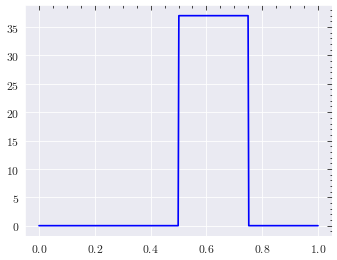

In [5]:
# Define the function
def func(x, rate, l, u):
    return rate * ((x >= l) & (x <= u))

rate = 37
l, u = 0.5, 0.75

x_values = np.linspace(0, 1, 400)
y_values = np.array([func(x, rate, l, u) for x in x_values])
x_ones = x_values[y_values == 1]

plt.plot(x_values, y_values, label=f'f with rate={rate}', color='blue')

plt.fill_between(x_values, 0, 1, where=((x_values >= x_ones[0]) & (x_values <= x_ones[-1])),
                 color='blue', label='Area of f(x)=1', alpha=0.2)

first_point_x = x_ones[0]
last_point_x = x_ones[-1]
first_point_y = 1
last_point_y = 1
plt.scatter(first_point_x, first_point_y, color='red', zorder=5, label=f"x = {first_point_x:.3f}, y = {first_point_y}")
plt.scatter(last_point_x, last_point_y, color='orange', zorder=5, label=f"x = {last_point_x:.3f}, y = {last_point_y}")

plt.title(f"Decay function for rate={rate}")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
if not os.path.isdir(f'plots/decay_function/'):
    os.makedirs(f'plots/decay_function/')
plt.savefig(f'plots/naive_function/naive_function_rate_focused_on_({l}_{u}).png')
plt.show()


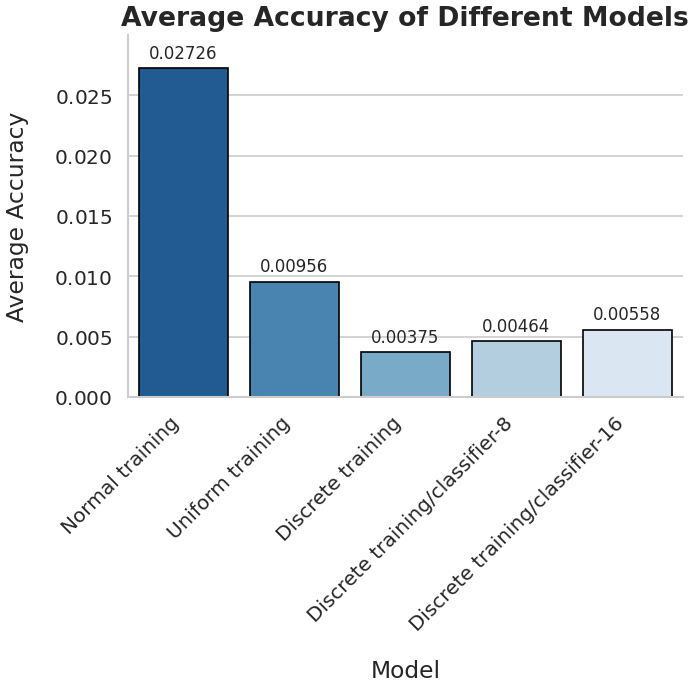

In [9]:
# Data
data = {
    "Model": [
        "Normal training",
        "Uniform training",
        "Discrete training",
        "Discrete training/classifier-8",
        "Discrete training/classifier-16"
    ],
    "[0, 0.25]": [0.03187, 0.00908, 0.00303, 0.00334, 0.00345],
    "[0.25, 0.5]": [0.02873, 0.00639, 0.00314, 0.00438, 0.00488],
    "[0.5, 0.75]": [0.02370, 0.01063, 0.00360, 0.00503, 0.00723],
    "[0.75, 1]": [0.02473, 0.01214, 0.00524, 0.00582, 0.00678]
}

df = pd.DataFrame(data)
df['avg_accuracy'] = df.loc[:, "[0, 0.25]": "[0.75, 1]"].mean(axis=1)

plt.figure(figsize=(6, 6))  
sns.set_theme(style="whitegrid")  

colors = sns.color_palette("Blues_r", len(df))  

ax = sns.barplot(x='Model', y='avg_accuracy', data=df, palette=colors, edgecolor="black")

# Customize labels and title
plt.xlabel('Model', fontsize=14, labelpad=15)  # Add padding and increase font size
plt.ylabel('Average Accuracy', fontsize=14, labelpad=15)
plt.title('Average Accuracy of Different Models', fontsize=16, fontweight='bold')

# Improve tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of bars (optional, but often helpful)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.5f}",  # Format to 5 decimal places
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),  # Offset the text above the bar
                textcoords='offset points',
                fontsize=10)


# Adjust y-axis limits to start from 0 (usually good practice for bar plots)
plt.ylim(0, df['avg_accuracy'].max() * 1.1)  # Add some extra space at the top

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Save the plot with higher resolution
plt.savefig('plots/accuracy_bar_plot.png', dpi=300)  # Use 300 DPI for publication-quality
plt.show()

In [ ]:
# Compare Discrete vs General Strategy
results = {}

In [ ]:
save = True
fig = plt.figure(figsize = (24, 4))
for i, model_name in enumerate([f'Intgen_({l}, {u})', f'Intdisc_({l}, {u})']):
    curve_m, curve_t, curve_std = results[model_name]['Mean'], results[model_name]['True'], results[model_name]['Std']
    plt.fill_between(np.arange(len(curve_m)),curve_m - curve_std , curve_m + curve_std,color = colors[i], linewidth = 1, linestyle = '-', alpha= .5)
    plt.plot(curve_t ,color = 'white',  linewidth = 1, linestyle = ':')
    plt.plot(curve_m ,color = colors[i], linewidth = 1, linestyle = '-', label = model_name)
    plt.fill_between([0,trues.shape[0] + trues[0,:, N].size],[l,l], [u,u],color ='lightsteelblue', alpha= .2)
plt.legend()
if save:
    plt.savefig('plots/Intdisc_vs_Intgen_nrmdeltas_True_bs16_intcls_True.png')
plt.show()

In [ ]:
class ResultsEvaluator:
    def __init__(self, model_base_path, results_base_path):
        self.results_base_path = results_base_path

        self.model_results = {}
        for results_dir in os.listdir(results_base_path):
            if os.path.isdir(os.path.join(results_base_path, results_dir)):
                tmp = results_dir.split('_')
                model_name = tmp[0] + tmp[1]
                self.model_results.setdefault(model_name, []).append(
                    {
                        'args': pickle.load(open(os.path.join(model_base_path, results_dir, 'args.pk'), 'rb')),
                        'pred': np.load(open(os.path.join(results_base_path, results_dir, 'pred.npy'), 'rb')),
                        'true': np.load(open(os.path.join(results_base_path, results_dir, 'true.npy'), 'rb')),
                        'metrics': np.load(open(os.path.join(results_base_path, results_dir, 'metrics.npy'), 'rb')),
                    }
                )

    def plot_results(self, specific_model, nr_samples_to_plot, feature_index, save_path=None, systematic = True):
        num_samples = self.model_results[list(self.model_results.keys())[0]][0]['true'].shape[0]
        T = self.model_results[list(self.model_results.keys())[0]][0]['true'][:, 0, 0].size
        if systematic:
            sample_indices = np.arange(0, T, 4).astype(int)
        else:
            sample_indices = np.random.choice(num_samples, min(num_samples, nr_samples_to_plot), replace=False)

        layout = pd.DataFrame().hvplot()

        for i, t in enumerate(sample_indices):
            df = pd.DataFrame({'True': self.model_results[list(self.model_results.keys())[0]][0]['true'][t, :, feature_index], 'index': np.arange(t, t+ 24)})
            plot = df.hvplot.line(y='True', x='index',label='True', color='black')
            for model_name, model_results in self.model_results.items():
                if specific_model not in model_name:
                    continue
                for i, model_result in enumerate(model_results):
                    pred_values = model_result['pred'][t, :, feature_index]
                    model_args = model_result['args']
                    df = pd.DataFrame({f'Pred: {model_name}': pred_values, 'index': np.arange(t, t+ 24)})
                    plot *= df.hvplot(x='index' , y=f'Pred: {model_name}', label=f'Pred: {model_name}',
                                         alpha=1, color ='red', line_width = .8 )

            plot.opts(title=f'Sample t={t}', xlabel='Time', ylabel='Value' ,width= 1000, height = 600)
            layout *= plot

        if save_path:
            hv.save(layout, save_path)

        return layout

# l, u = 0, 0.25
# subprocess.run(
#     ["bash", "./scripts/multivariate_forecasting/Wireless/stats.sh", str(l), str(u)],
#     capture_output=True,
#     text=True,
#     check=True  
# )
# model_evaluator = ResultsEvaluator('checkpoints', 'results')
# layout = model_evaluator.plot_results(f'Intdisc', 2, 0) *\
#     hv.Rectangles([(-10, l, 550, u)]).opts(color='orange', alpha=0.3)
# layout.opts(width = 1500)

# l, u = 0.25, 0.5
# subprocess.run(
#     ["bash", "./scripts/multivariate_forecasting/Wireless/stats.sh", str(l), str(u)],
#     capture_output=True,
#     text=True,
#     check=True  
# )
# model_evaluator = ResultsEvaluator('checkpoints', 'results')
# layout = model_evaluator.plot_results(f'Intdisc', 2, 0) *\
#     hv.Rectangles([(-10, l, 550, u)]).opts(color='orange', alpha=0.3)
# layout.opts(width = 1500)

# l, u = 0.5, 0.75
# subprocess.run(
#     ["bash", "./scripts/multivariate_forecasting/Wireless/stats.sh", str(l), str(u)],
#     capture_output=True,
#     text=True,
#     check=True  
# )
# model_evaluator = ResultsEvaluator('checkpoints', 'results')
# layout = model_evaluator.plot_results(f'Intdisc', 2, 0) *\
#     hv.Rectangles([(-10, l, 550, u)]).opts(color='orange', alpha=0.3)
# layout.opts(width = 1500)

# l, u = 0.75, 1
# subprocess.run(
#     ["bash", "./scripts/multivariate_forecasting/Wireless/stats.sh", str(l), str(u)],
#     capture_output=True,
#     text=True,
#     check=True  
# )
# model_evaluator = ResultsEvaluator('checkpoints', 'results')
# layout = model_evaluator.plot_results(f'Intdisc', 2, 0) *\
#     hv.Rectangles([(-10, l, 550, u)]).opts(color='orange', alpha=0.3)
# layout.opts(width = 1500)

In [ ]:
# model_evaluator = ResultsEvaluator('checkpoints', 'results')
# layout = model_evaluator.plot_results(f'Intnone', 2, 0)
# layout.opts(width = 1500)

In [ ]:
# model_evaluator = ResultsEvaluator('checkpoints', 'results')
# layout = model_evaluator.plot_results(f'Intgen', 2, 0) 
# layout.opts(width = 1500)

In [ ]:
# l, u = 0, 0.25
# model_evaluator = ResultsEvaluator('checkpoints', 'results')
# layout = model_evaluator.plot_results(f'Intspec({l}, {u})', 2, 0) 
# layout.opts(width = 1500, ylim = (0,1))

In [ ]:
# l, u = 0.25, 0.5
# model_evaluator = ResultsEvaluator('checkpoints', 'results')
# layout = model_evaluator.plot_results(f'Intspec({l}, {u})', 2, 0) 
# layout.opts(width = 1500)

In [ ]:
# l, u = 0.5, 0.75
# model_evaluator = ResultsEvaluator('checkpoints', 'results')
# layout = model_evaluator.plot_results(f'Intspec({l}, {u})', 2, 0) 
# layout.opts(width = 1500)

In [ ]:
# l, u = 0.75, 1
# model_evaluator = ResultsEvaluator('checkpoints', 'results')
# layout = model_evaluator.plot_results(f'Intspec({l}, {u})', 2, 0) 
# layout.opts(width = 1500)

In [ ]:
intervals_to_evaluate = []
intervals_to_evaluate_none = []
intervals_to_evaluate_gen = []
intervals_to_evaluate_disc = []
max_val, min_val = 1, 0

# while len(intervals_to_evaluate) < 40:
#     a = (max - min) * np.random.rand() + min
#     b = (max - min) * np.random.rand() + min
#     if a > b:
#         a, b = b, a  
        
#     if not any(np.allclose([a, b], interval) for interval in intervals_to_evaluate):
#         intervals_to_evaluate.append([a, b])

interval_lengths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_intervals_per_length = [5, 10, 5, 5, 5, 0, 0, 0, 0, 0]  

for length, num_intervals in zip(interval_lengths, num_intervals_per_length):
    count = 0
    while count < num_intervals:
        a = (max_val - min_val - length) * np.random.rand() + min_val
        b = a + length
            
        if not any(np.allclose([a, b], interval) for interval in intervals_to_evaluate):
            intervals_to_evaluate.append([a, b])
            count += 1

intervals_to_evaluate = [[0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1]]
w_hat_values = [0, 0.05, 0.1, 0.15, 0.2]
intervals_to_evaluate, w_hat_values

In [ ]:
def calculate_avg_accuracies(intervals_to_evaluate, w_hat_values):
    avg_accuracies = []
    for w_hat in w_hat_values:
        print(f"Processing w_hat value: {w_hat}")

        try:
            subprocess.run(
                ["bash", "./scripts/multivariate_forecasting/Wireless/train.sh", str(w_hat)],
                capture_output=True,
                text=True,
                check=True  
            )

            intervals_to_evaluate_none = []
            intervals_to_evaluate_gen = []
            intervals_to_evaluate_disc = []

            for interval in intervals_to_evaluate:
                print(f"Evaluating interval: {interval}")

                try:
                    # Run stats script
                    subprocess.run(
                        ["bash", "./scripts/multivariate_forecasting/Wireless/stats.sh", str(interval[0]), str(interval[1])],
                        capture_output=True,
                        text=True,
                        check=True  
                    )

                    # Load metrics files
                    intnone_metrics = np.load(f'results/Intnone_iTransformer_custom_M_ft48_sl48_ll24_pl32_dm8_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0/metrics.npy')
                    intgen_metrics = np.load(f'results/Intgen_iTransformer_custom_M_ft48_sl48_ll24_pl32_dm8_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0/metrics.npy')
                    intdisc_metrics = np.load(f'results/Intdisc_iTransformer_custom_M_ft48_sl48_ll24_pl32_dm8_nh2_el1_dl128_df1_fctimeF_ebTrue_dtExp_projection_0/metrics.npy')

                    # Extract MAE values
                    intnone_mae, intgen_mae, intdisc_mae = intnone_metrics[0], intgen_metrics[0], intdisc_metrics[0]

                    intervals_to_evaluate_none.append([interval[0], interval[1], intnone_mae])
                    intervals_to_evaluate_gen.append([interval[0], interval[1], intgen_mae])
                    intervals_to_evaluate_disc.append([interval[0], interval[1], intdisc_mae])

                except FileNotFoundError:
                    print(f"Metrics file not found for interval {interval}. Skipping.")
                except subprocess.CalledProcessError as e:
                    print(f"Error running stats.sh for interval {interval}: {e}")

            # Create DataFrames
            intervals_to_evaluate_none_df = pd.DataFrame(intervals_to_evaluate_none, columns=['Interval Start', 'Interval End', 'MAE'])
            intervals_to_evaluate_gen_df = pd.DataFrame(intervals_to_evaluate_gen, columns=['Interval Start', 'Interval End', 'MAE'])
            intervals_to_evaluate_disc_df = pd.DataFrame(intervals_to_evaluate_disc, columns=['Interval Start', 'Interval End', 'MAE'])

            # Calculate average accuracies
            avg_mae_intnone = intervals_to_evaluate_none_df.loc[:, 'MAE'].mean()
            avg_mae_intgen = intervals_to_evaluate_gen_df.loc[:, 'MAE'].mean()
            avg_mae_intdisc = intervals_to_evaluate_disc_df.loc[:, 'MAE'].mean()

            avg_accuracies.append([w_hat, avg_mae_intnone, avg_mae_intgen, avg_mae_intdisc])

            # Print interval averages for each model
            print(f"For w_hat={w_hat}:")
            print(f"  Intnone: {avg_mae_intnone}")
            print(f"  Intgen: {avg_mae_intgen}")
            print(f"  Intdisc: {avg_mae_intdisc}")
            print()

        except subprocess.CalledProcessError as e:
            print(f"Error running train.sh for w_hat={w_hat}: {e}")
            avg_accuracies.append([w_hat, np.nan, np.nan, np.nan])

    return avg_accuracies

In [ ]:
intervals_to_evaluate = [[0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1]]
w_hat_values = [0.25, 0.35, 0.4]

avg_accuracies = calculate_avg_accuracies(intervals_to_evaluate, w_hat_values)

df = pd.DataFrame(avg_accuracies, columns=['w_hat', 'Intnone', 'Intgen', 'Intdisc'])
df = df.set_index('w_hat')

print("\nTable: Average Accuracies for Each Model and w_hat Value")
print(df.to_markdown(numalign="left", stralign="left"))
print(df)

In [ ]:
def plot_3d_mae_plotly(df, model_name):
    x = df['Interval Start']
    y = df['Interval End']
    z = df['MAE']

    x_new = np.linspace(x.min(), x.max(), 100)
    y_new = np.linspace(y.min(), y.max(), 100)
    x_grid, y_grid = np.meshgrid(x_new, y_new)
    z_grid = griddata((x, y), z, (x_grid, y_grid), method='cubic')

    fig = go.Figure(data=[
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=5,
                color=z,
                colorscale='Viridis',
                colorbar=dict(title="MAE"),
                opacity=0.8
            )
        ),
        go.Surface(
            x=x_grid,
            y=y_grid,
            z=z_grid,
            colorscale='Viridis',
            opacity=0.7,
            showscale=False
        )
    ])

    fig.update_layout(
        title=f'MAE for {model_name} Model',
        scene=dict(
            xaxis_title='Interval Start',
            yaxis_title='Interval End',
            zaxis_title='MAE'
        ),
        width=1000,  
        height=800   
    )
    
    fig.show()

In [ ]:
# plot_3d_mae_plotly(intervals_to_evaluate_none_df, 'Intnone')

In [ ]:
# plot_3d_mae_plotly(intervals_to_evaluate_gen_df, 'Intgen')

In [ ]:
# plot_3d_mae_plotly(intervals_to_evaluate_disc_df, 'Intdisc')

In [ ]:
def plot_mae_vs_interval_length(intervals_to_evaluate_none_df, intervals_to_evaluate_gen_df, intervals_to_evaluate_disc_df, threshold=0.01):
    fig = go.Figure()

    def group_and_average(df, threshold):
        df['Interval Length'] = df['Interval End'] - df['Interval Start']
        df = df.sort_values('Interval Length')

        grouped_data = []
        current_group = []
        for i in range(len(df)):
            if i == 0:
                current_group.append(df.iloc[i])
            else:
                if abs(df.iloc[i]['Interval Length'] - current_group[-1]['Interval Length']) <= threshold:
                    current_group.append(df.iloc[i])
                else:
                    grouped_data.append(current_group)
                    current_group = [df.iloc[i]]

        if current_group:
            grouped_data.append(current_group)

        averaged_data = []
        for group in grouped_data:
            avg_length = np.mean([row['Interval Length'] for row in group])
            avg_mae = np.mean([row['MAE'] for row in group])
            averaged_data.append((avg_length, avg_mae))

        return pd.DataFrame(averaged_data, columns=['Interval Length', 'MAE'])

    averaged_none = group_and_average(intervals_to_evaluate_none_df, threshold)
    averaged_gen = group_and_average(intervals_to_evaluate_gen_df, threshold)
    averaged_disc = group_and_average(intervals_to_evaluate_disc_df, threshold)

    fig.add_trace(go.Scatter(
        x=averaged_none['Interval Length'],
        y=averaged_none['MAE'],
        mode='markers+lines',
        name='Normal training'
    ))

    fig.add_trace(go.Scatter(
        x=averaged_gen['Interval Length'],
        y=averaged_gen['MAE'],
        mode='markers+lines',
        name='Uniform interval sampling'
    ))

    fig.add_trace(go.Scatter(
        x=averaged_disc['Interval Length'],
        y=averaged_disc['MAE'],
        mode='markers+lines',
        name='Discrete interval sampling'
    ))

    fig.update_layout(
        title='MAE vs. Interval Length',
        xaxis_title='Interval Length',
        yaxis_title='MAE'
    )

    fig.show()

In [ ]:
# plot_mae_vs_interval_length(intervals_to_evaluate_none_df, intervals_to_evaluate_gen_df, intervals_to_evaluate_disc_df, threshold=0)